In [19]:
graph = nx.Graph()
print(graph)

Graph with 0 nodes and 0 edges


In [20]:
# This is a trick taught by Jesús to include the directory containing the source 
# within the notebook scope
import sys
sys.path.append('../')

In [376]:
import networkx as nx
import spacy 
from spacy.lang.es.examples import sentences
import itertools as it
import matplotlib.pyplot as plt

from spacy.symbols import nsubj, VERB, root, ORTH, PUNCT

DEPS_TO_FOLLOW = ['nmod', 'appos', 'nummod', 'acl', 'amod', 'det', 'clf', 'case']
POS_TO_AVOID = [PUNCT]

MODEL = 'es_core_news_sm'
MODEL = 'es_core_news_lg'

# MODEL = 'en_core_web_md'
# MODEL = 'es_core_news_lg'

# we centralize the extraction
nlp = spacy.load(MODEL)

# Add special case rule
special_case = [{ORTH: "D/Dª"}]
nlp.tokenizer.add_special_case("D/Dª", special_case)

# pattern = [{'LIKE_NUM': True},
#            {'IS_LOWER': True}]

ruler = nlp.add_pipe("entity_ruler")
patterns = [ {"label": "DNI", "pattern": [{"TEXT": {"REGEX": ".*?[0-9]{8}[A-Z]"}}]}, 
             {"label": "DNI", "pattern": [{"LOWER": "dni"}, {"TEXT": {"REGEX": ".*?[0-9]{8}[A-Z]"}}] },
             {"label": "DNI", "pattern": [{"LOWER": "dni"}, {}, {"TEXT": {"REGEX": ".*?[0-9]{8}[A-Z]"}}] },
           ]
ruler.add_patterns(patterns)


def is_idx_part_of_entity(idx,dep_parse):
    # print(f'is_idx: {idx} - {dep_parse[idx]}')
    for i in range(len(dep_parse.ents)):
        # print(f'ent: {dep_parse.ents[i].start} - {dep_parse.ents[i].end} : {[dep_parse[x] for x in range(dep_parse.ents[i].start, dep_parse.ents[i].end)]}')
        if dep_parse.ents[i].start <= idx and idx <= dep_parse.ents[i].end:
            return True
    return False

def build_graph_from_dependencies (doc): 
    edges = []
    edge_labels = {}
    roots = []
    for token in doc:
        if token.dep_=='ROOT': 
            roots.append(token)
        for child in token.children:
            edges.append(('{0}'.format(token.i),
                          '{0}'.format(child.i)))
            edge_labels [('{0}'.format(token.i),
                          '{0}'.format(child.i)) ]= child.dep_
    if len(roots) > 1: 
        # we have to reconstruct the graph -- maybe bad partitioning due to punctuation in our context
        # This is completely heuristic as we are dealing with Spanish texts, we try to reconstruct the 
        # connectivity of the sentence by assuming local dependency 
        # if we don't see any punctuation nearby => we include a meta-root node
        sorted_roots = sorted(roots, key=lambda x: x.i)
        meta_roots = set()
        meta_roots.add(sorted_roots[0])
        sorted_roots.pop(0)
        for crt_root in sorted_roots: 
            if crt_root.i-2 > 0: 
                if doc[crt_root.i-1].pos == PUNCT: 
#                     print (f'{crt_root} - {doc[crt_root.i-2]}')
                    edges.append(('{0}'.format(crt_root.i),
                                  '{0}'.format(crt_root.i-2)))
                    edge_labels [('{0}'.format(crt_root.i),
                          '{0}'.format(crt_root.i-2)) ]= 'REC'
                else: 
                    meta_roots.add(crt_root)
            else: 
                meta_roots.add(crt_root)
        if len(meta_roots) >1: 
            for crt_root in meta_roots: 
                edges.append(('-1','{0}'.format(crt_root.i)))
                edge_labels [('-1','{0}'.format(crt_root.i)) ]= 'META_ROOT'
    
    graph = nx.Graph()
    graph.add_edges_from(edges)
    
    color_state_map = {'no_root': 'pink', 'root': 'red', 'meta_root': 'blue'}
    states = ['meta_root' if node=='-1' else 'root' if doc[int(node)].dep_ == 'ROOT'  else 'no_root' for node in graph.nodes()]
    nx.set_node_attributes(graph, dict(zip(graph.nodes(), states)), 'state')
    node_labels = {n:doc[int(n)] for n in graph.nodes()}
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(graph, seed=225, )  # Seed for reproducible layout
    pos = nx.planar_layout(graph)
#     pos = nx.kamada_kawai_layout(graph)
    nx.draw(
        graph, pos, edge_color='black', width=1, linewidths=1, 
        node_color=[color_state_map[node[1]['state']] for node in graph.nodes(data=True)], 
        alpha=0.9,
        labels=node_labels
    )
    nx.draw_networkx_edge_labels(
        graph, pos, edge_labels=edge_labels,
        font_color='red'
    )
    plt.show()
    return graph

def check_path_crossing_another_entity (doc, path): 
    if (len(path) == 2): 
        return False
    else: 
        return any([ent.start<= int(idx) and int(idx)<ent.end for idx in path[1:-1] for ent in doc.ents ])
    

def shortest_dependency_path(graph, e1=None, e2=None):
    ## CB: This should also work for NERs, if the dep parsing is pointing at the
    ## head of the entity,
    ## However, the NE would not be added completely
    shortest_path = []
    try:
        # print (f'looking shortest path from {e1.i} to {e2.i}')
        shortest_path = nx.shortest_path(graph, source=str(e1.i), target=str(e2.i))
    except nx.NetworkXNoPath:
        print (f'problems with shortest_path - {str(e1.i)} {doc[e1.i]} - {str(e2.i)} {doc[e2.i]}')
        print (graph)
        shortest_path=[]
    return shortest_path


# if any children decides to return an emtpy list, we will discard that path
def explore_children_recursively (idx, doc):
#     print (f'word {idx} {doc[idx]}')
    aux_it=[c for c in doc[idx].children]
    if (len(aux_it) == 0): 
        # we are in a leaf
        if not is_idx_part_of_entity (idx, doc): 
            return [idx]
        else: 
            return []
    else: 
        aux_children = []
        for c in doc[idx].children: 
            aux_children.append(explore_children_recursively(c.i, doc))
#         print(f'aux_children -- explore: {aux_children}')
        aux_result = []
        if (all([len(x) > 0 for x in aux_children])): 
            aux_result = []
            for x in aux_children: 
                aux_result += x
            aux_result.insert(0, idx)
#         print(f'aux_result -- explore: {aux_result}')
        return aux_result

def obtain_children_pruning(idx, doc):
    to_process = [c for c in doc[idx].children if c.dep_ in DEPS_TO_FOLLOW]
#     print(f'-------------')
#     print(f'first word: {idx} {doc[idx]}')
#     print(f'initial: {[x.i for x in to_process]} {[doc[x.i] for x in to_process]}')
    children=[]
    for c in to_process: 
        children += explore_children_recursively(c.i, doc)
    return sorted(children)  

def add_children_deps(path, dep_parse):
    children_start = obtain_children_pruning(int(path[0]), dep_parse)
    children_end = obtain_children_pruning(int(path[-1]), dep_parse)
#     print (f'children start: {children_start}')
#     print (f'children end: {children_end}')
    added_children = [x for x in children_start if not is_idx_part_of_entity(int(x), dep_parse)]
#     print(f'chidren added: {added_children}')
    added_children += [x for x in children_end if x not in added_children and int(path[0]) <= int(x) and int(x) <= int(path[-1]) and not is_idx_part_of_entity(int(x), dep_parse)]
#     print(f'chidren added: {added_children}')
    test = [int(x) for x in path]
#     print(f'test: {test} {[doc[x] for x in test]}')
    test += [int(x) for x in added_children if x not in path]
#     print(f'test: {test} {[doc[x] for x in test]}')
#     print(f'Children: {added_children}')
    if int(path[0]) < int(path[-1]):
        return sorted([int(x) for x in test])
    else:
        return sorted([int(x) for x in test],reverse=True)

def build_pattern_and_pos_pattern(doc, start_ent, end_ent, path):
    path = sorted(path)
    shortest_path = ''
    pos_tags = []
    idx = 0
    while idx<len(path): 
        if (path[idx] == start_ent.start): 
            shortest_path += ' ' + start_ent.label_+'_<'+ str(doc[start_ent.start:start_ent.end]) + '> '
            pos_tags.append('<' + start_ent.label_ + '>')
            while (idx<len(path)) and (path[idx]<start_ent.end): 
                idx+=1
        elif (path[idx] == end_ent.start): 
            shortest_path += ' '+end_ent.label_+'_<'+str(doc[end_ent.start:end_ent.end])+'> '
            pos_tags.append('<' + end_ent.label_ + '>')
            while (idx<len(path)) and (path[idx]<end_ent.end): 
                idx+=1
        else: 
            shortest_path += ' '+doc[path[idx]].text
            pos_tags.append(doc[path[idx]].pos_)
            idx += 1
    return shortest_path.strip(), pos_tags
    
def generate_textual_patterns_with_pos_tags(corpus, extend_children=False):
    """A method to generate textual patterns given the corpus.

    Parameters
    ----------
    corpus : type List
        List of sentences is passed.

    Returns
    -------
    type List
        List of textual patterns

    """

    patterns_pos_tags = []
    textual_patterns = []
    for i, sentence in enumerate(corpus):
        dep_parse = nlp(sentence)
#         print(f'ents: {dep_parse.ents}')
        graph = build_graph_from_dependencies(dep_parse)
        try:
            if len(dep_parse.ents) == 2:
                path = shortest_dependency_path(graph, dep_parse[dep_parse.ents[0].start], dep_parse[dep_parse.ents[1].start])
                if len(path) >= 2:
                    if (extend_children):
                        path = add_children_deps(path, dep_parse)
                    else:
                        path = [int (x) for x in path]
                    # print (f'path: {path}')
                    ## we add the entity and its POS in parallel
                    shortest_path = dep_parse.ents[0].label_+'_<'+str(dep_parse[dep_parse.ents[0].start:dep_parse.ents[0].end]) + '> '
                    pos_tags = ['<'+dep_parse.ents[0].label_+'>']
                    ## we add all the words in the middle in the same order
                    shortest_path += ' '.join([dep_parse[j].text for j in path[1:-1]])
                    for j in path[1:-1]:
                        pos_tags.append(dep_parse[j].pos_)
                    ## and now the last entity
                    shortest_path += ' '+dep_parse.ents[1].label_+'_<'+str(dep_parse[dep_parse.ents[1].start:dep_parse.ents[1].end]) + '> '
                    pos_tags.append('<'+dep_parse.ents[1].label_+'>')
                    # TODO: update the way of extending with advmod (not yet)
                    # textual_patterns.append(adv_mod_deps(shortest_path, dep_parse))
                    textual_patterns.append(shortest_path)
                    patterns_pos_tags.append(pos_tags)
            elif len(dep_parse.ents)> 2:
                pairs = it.combinations(dep_parse.ents, 2)
                paths = {}
                for pair in pairs:
                    print (pair)
                    path = shortest_dependency_path(graph, dep_parse[pair[0].start], dep_parse[pair[1].start])  
                    if len(path) >= 2:
                        if (extend_children):
                            path = add_children_deps(path, dep_parse)
                        else:
                            path = [int(x) for x in path]
                            # we store all the information to reconstruct the 
                        if (pair[0] not in paths): 
                            paths[pair[0]] = []
                        paths[pair[0]].append({'path':path, 'ents':(pair[0], pair[1])})
#                 print(f'paths: {paths}')
                # we now clean the possible overlaps for the paths starting in the same entity
                for start_ent in paths:
#                     print (f'{start_ent}')
#                     print(f'{paths[start_ent]}')
                    if len(paths[start_ent]) > 1: 
                        sorted_paths = sorted(paths[start_ent], key=lambda x: len(x['path']))
                        cleaned_paths = [] 
                        cleaned_paths.append(sorted_paths[0])
                        for current_idx in range(1,len(sorted_paths)): 
                            cleaned_path = sorted_paths[current_idx]['path']
#                             print(f'before: {cleaned_path} {[dep_parse[x] for x in cleaned_path]}')
                            for prev_idx in range(len(cleaned_paths)):
#                                 print(f'against: {sorted_paths[prev_idx]["path"]} {[dep_parse[x] for x in cleaned_path]}')
                                cleaned_path = [x for x in cleaned_path if x not in sorted_paths[prev_idx]['path']
                                                           or (start_ent.start <= x and x <= (start_ent.end))]
#                             print(f'after: {cleaned_path} {[dep_parse[x] for x in cleaned_path]}')
                            cleaned_paths.append({'path':cleaned_path, 'ents':sorted_paths[current_idx]['ents']})
#                         print(f'cleaned_paths: {cleaned_paths}')
                        for current_idx in range(len(cleaned_paths)): 
                            shortest_path, pos_tags = build_pattern_and_pos_pattern(dep_parse, 
                                                                                  cleaned_paths[current_idx]['ents'][0], 
                                                                                  cleaned_paths[current_idx]['ents'][1], 
                                                                                  cleaned_paths[current_idx]['path'] )
                            # TODO: update this
                            # textual_patterns.append(adv_mod_deps(shortest_path, dep_parse))
                            textual_patterns.append(shortest_path)
                            patterns_pos_tags.append(pos_tags)
                    else: 
#                         print(f'llegue')
                        shortest_path, pos_tags = build_pattern_and_pos_pattern(dep_parse, 
                                                                                  paths[start_ent][0]['ents'][0], 
                                                                                  paths[start_ent][0]['ents'][1], 
                                                                                  paths[start_ent][0]['path'] )
#                         print(f'sali')

                        textual_patterns.append(shortest_path)
                        patterns_pos_tags.append(pos_tags)
        except Exception as e:
            print (e)
            pass
    return textual_patterns, patterns_pos_tags




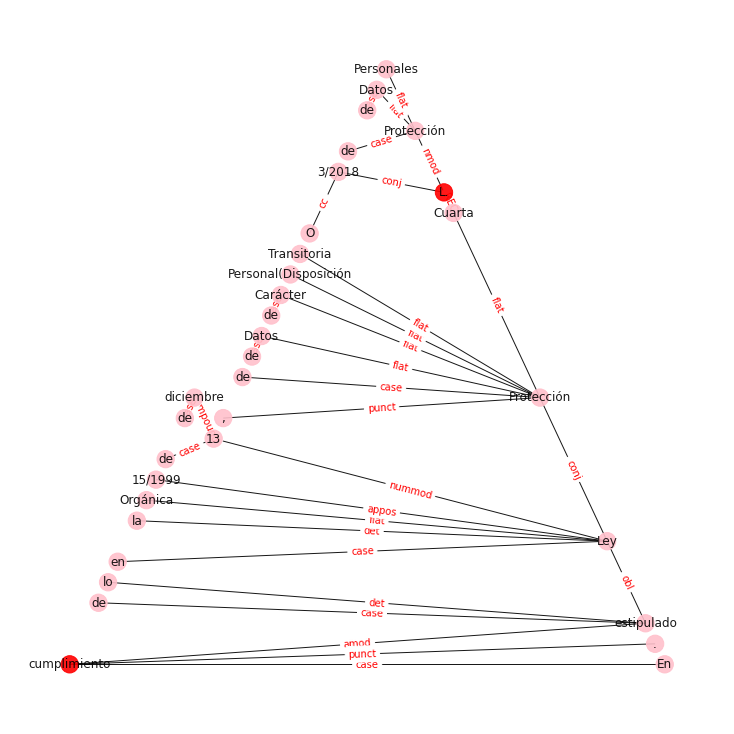

(Ley Orgánica, Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta)
(Ley Orgánica, L.)
(Ley Orgánica, Protección de Datos Personales)
(Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta, L.)
(Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta, Protección de Datos Personales)
(L., Protección de Datos Personales)


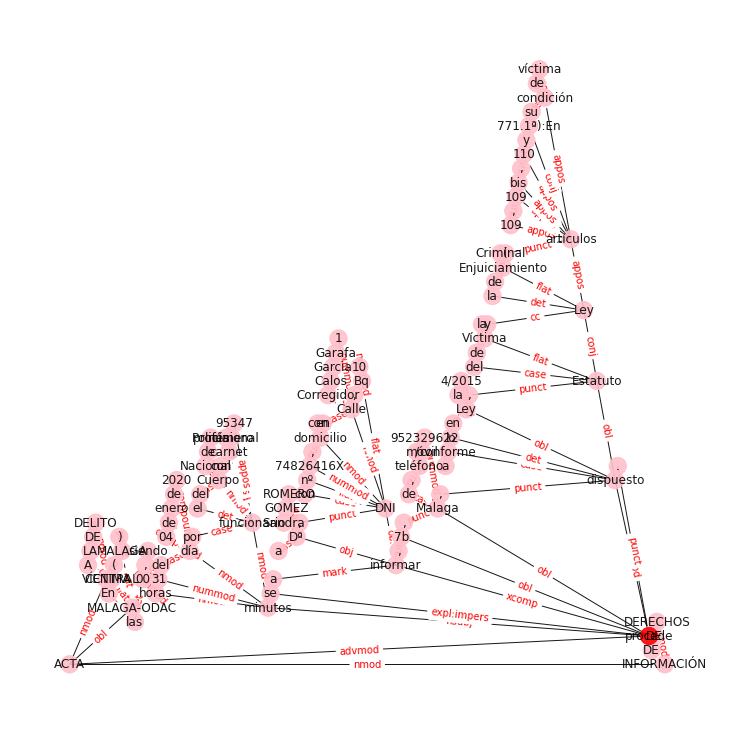

(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, MALAGA)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, Cuerpo Nacional de Policía)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, Dª Sandra GOMEZ ROMERO)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, DNI)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, 74826416X)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, Calle Corregidor Calos Garcia Garafa)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, Bq 10)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, Malaga)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, la Ley)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, Estatuto de la Víctima)
(INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO, Ley de Enjuiciamiento Criminal)
(MALAGA, Cuerpo Nacional de Policía)
(MALAGA, Dª Sandra GOMEZ ROMERO)
(MALAGA, DNI)
(MALAGA, 74826416X)
(MALAGA, Calle Corregidor Calos Garcia Garafa)
(MALAGA, Bq 10)
(MALAGA, Malaga)
(MALAGA, la Ley)
(MALAGA, Estatuto de la Víctima)
(MALAGA, Ley de Enjuiciamiento Cri

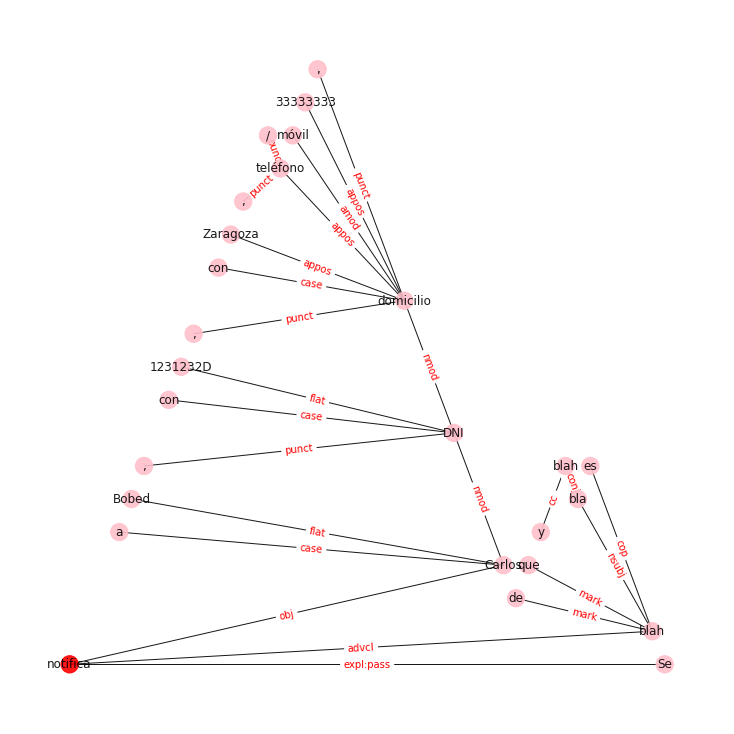

(Carlos Bobed, DNI 1231232D)
(Carlos Bobed, Zaragoza)
(DNI 1231232D, Zaragoza)
size: 75
en la MISC_<Ley Orgánica>  de 13 de diciembre de MISC_<Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta>
MISC_<Ley Orgánica>  Cuarta PER_<L.>
MISC_<Ley Orgánica>  de MISC_<Protección de Datos Personales>
de MISC_<Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta>  PER_<L.>
MISC_<Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta>  de MISC_<Protección de Datos Personales>
PER_<L.>  de MISC_<Protección de Datos Personales>
ACTA DE ORG_<INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO>  MALAGA-ODAC LOC_<MALAGA>
ORG_<INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO>  procede de LOC_<Malaga>
ORG_<INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO>  informar a PER_<Dª Sandra GOMEZ ROMERO>
ORG_<INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO>  con LOC_<DNI>
ORG_<INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO>  DNI_<74826416X>
ORG_<INFORMACIÓN DE DERE

In [379]:
sents = []
# for s in sentences:
#     sents.append(s)
sents.append('En cumplimiento de lo estipulado en la Ley Orgánica 15/1999 de 13 de diciembre, de Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta. L. O 3/2018 de Protección de Datos Personales')
sents.append('ACTA DE INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO En MALAGA-ODAC CENTRAL (MALAGA), siendo las 00 horas 31 minutos del día 04 de enero de 2020 por el funcionario del Cuerpo Nacional de Policía con carnet profesional número 95347 se procede a informar a Dª Sandra GOMEZ ROMERO, con DNI nº 74826416X, con domicilio en Calle Corregidor Calos Garcia Garafa 1, Bq 10, 7b , de Malaga , teléfono/móvil 952329622 , conforme a lo dispuesto en la Ley 4/2015, del Estatuto de la Víctima y la Ley de Enjuiciamiento Criminal (artículos 109, 109 bis, 110 y 771.1ª):En su condición de víctima.')
sents.append("Se notifica a Carlos Bobed, con DNI 1231232D, con domicilio Zaragoza, teléfono/móvil 33333333, de que bla y blah es blah")

textual_patterns, post = generate_textual_patterns_with_pos_tags(sents, True)
print(f'size: {len(textual_patterns)}')
for pat in textual_patterns: 
    print(pat)
print (f'Done. ')

In [369]:
 doc = nlp(sents[-1])
doc

Se notifica a Carlos Bobed, con DNI 1231232D, domicilio en Zaragoza, teléfono/móvil 33333333, de que bla y blah es blah

In [193]:
doc[0].children

In [59]:
for child in doc[0].children: 
    print (f'{child} - {child.head} - {child.dep_}')

INFORMACIÓN - ACTA - nmod
VÍCTIMA - ACTA - nmod
MALAGA-ODAC - ACTA - obl


ACTA DE INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO En MALAGA-ODAC CENTRAL (MALAGA), siendo las 00 horas 31 minutos del día 04 de enero de 2020 por el funcionario del Cuerpo Nacional de Policía con carnet profesional número 0000 se procede a informar a D/Dª Manuela Restrigo, con DNI nº 11111123C, con domicilio en Calle Rute, 1,1 , teléfono/móvil 434342 , conforme a lo dispuesto en la Ley 4/2015, del Estatuto de la Víctima y la Ley de Enjuiciamiento Criminal (artículos 109, 109 bis, 110 y 771.1ª):En su condición de víctima.